In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy

π = np.pi
µs_to_ns = 1e3

In [2]:
#states
num_qubit_states = 3

g_state = qt.basis(num_qubit_states, 0)
e_state = qt.basis(num_qubit_states, 1)
f_state = qt.basis(num_qubit_states, 2)

#operators
b1 = qt.tensor(qt.destroy(num_qubit_states), qt.qeye(num_qubit_states))
b1dag = b1.dag() 
b2 = qt.tensor(qt.qeye(num_qubit_states), qt.destroy(num_qubit_states))
b2dag = b2.dag() 

gg_proj = qt.tensor(g_state, g_state).proj()
ge_proj = qt.tensor(g_state, e_state).proj()
gf_proj = qt.tensor(g_state, f_state).proj()

eg_proj = qt.tensor(e_state, g_state).proj()
ee_proj = qt.tensor(e_state, e_state).proj()
ef_proj = qt.tensor(e_state, f_state).proj()

fg_proj = qt.tensor(f_state, g_state).proj()
fe_proj = qt.tensor(f_state, e_state).proj()
ff_proj = qt.tensor(f_state, f_state).proj()

In [3]:
def hamiltonian(omega_1, omega_2, alpha_1, alpha_2, J_coupling):
    t1 = (omega_1 * b1dag * b1) + (omega_2 * b2dag * b2)
    t2 = (alpha_1 / 2 * b1dag * b1dag * b1 * b1) + (alpha_2 / 2 * b2dag * b2dag * b2 * b2)
    t4 = J_coupling * (b1dag * b2 + b2dag * b1)
    t5 = J_coupling * (b1dag * b2dag + b1 * b2)
    return t1 + t2 + t5 +t4

In [4]:
def calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, plotbool):
    h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
    psi0 = qt.tensor(e_state, g_state) #start in eg state
    te = qt.mesolve(h, psi0, t_vec, [], []) #time evolve with t_vec
    eg_pops = qt.expect(eg_proj, te.states)
    argmin = np.argmin(np.abs(eg_pops-0.5)[1:]) + 1 #argument of value closest to 0.5
    if plotbool == True:
        fig = plt.figure()
        plt.plot(t_vec, eg_pops) #blue line
        plt.scatter(t_vec[argmin], eg_pops[argmin], c='r') #red dot 
    return eg_pops[argmin], t_vec[argmin], argmin

def compute_propogator(h, t_vec): #output propogator matrix
    propogator = qt.propagator(h, t_vec)
    prop = qt.Qobj(np.array(propogator[-1]))
    return prop

def fivetofour(matrix):
    matrix_4x5 = np.delete(matrix, 2, axis=0)
    matrix_4x4 = np.delete(matrix_4x5, 2, axis=1)
    return matrix_4x4

def compute_cz(phi): #output theoretical unitary evolution matrix
    matrix=qt.Qobj(np.array(
        qt.tensor(g_state, g_state).proj() * 1
        + qt.tensor(e_state, g_state).proj()
        + qt.tensor(g_state, e_state).proj()
        + qt.tensor(e_state, e_state).proj() * np.exp(1j*phi)))
    return qt.Qobj(fivetofour(np.array(matrix[0:5,0:5])))

SQiSW_matrix = np.array([[1, 0, 0, 0],
                         [0, (1/np.sqrt(2)), (1/np.sqrt(2))*(1j), 0],
                         [0, (1/np.sqrt(2))*(1j), (1/np.sqrt(2)), 0],
                         [0, 0, 0, 1]], dtype=complex)
SQiSW = qt.Qobj(SQiSW_matrix)

In [44]:
J_coupling = 2*π * 8
t_start = 0
t_end = 6 * π/(4*J_coupling) #π/4J ~ reach maximally entangled state (Jt = π/4)
t_vec = np.linspace(t_start, t_end/4, 601)
omega1 = 2*π * 6000
omega2 = 2*π * 6000
alpha = 2*π * -300

In [45]:
_, gatetime, _ = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, False)
h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
newt_vec = np.linspace(t_start, gatetime, 601)
propogator = compute_propogator(h, newt_vec)
propogator

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 9.99998978e-01+5.23637260e-04j  0.00000000e+00+0.00000000e+00j
  -3.20725977e-05-2.23776364e-05j  0.00000000e+00+0.00000000e+00j
  -1.32929080e-03+5.59798158e-05j  0.00000000e+00+0.00000000e+00j
  -3.20725977e-05-2.23776364e-05j  0.00000000e+00+0.00000000e+00j
   1.15340386e-06+2.66813092e-07j]
 [ 0.00000000e+00+0.00000000e+00j -7.58613035e-04+7.07105191e-01j
   0.00000000e+00+0.00000000e+00j  7.07106607e-01+7.59289937e-04j
   0.00000000e+00+0.00000000e+00j  9.57109483e-07-6.92549454e-04j
   0.00000000e+00+0.00000000e+00j -3.17488845e-04+8.91297732e-04j
   0.00000000e+00+0.00000000e+00j]
 [-3.20434465e-05-2.23572971e-05j  0.00000000e+00+0.00000000e+00j
   3.41792646e-01+9.36949555e-01j  0.00000000e+00+0.00000000e+00j
  -4.87932685e-02-3.26531448e-02j  0.00000000e+00+0.00000000e+00j
  -4.10467728e-02+1.31346346e-02j  0.00000000e+00+0.00000000e+00j
   7.18244746e-05+4.85917281e-05j]
 [ 0.0000000

In [46]:
gatetime

0.015625

In [47]:
temp1 = qt.Qobj(propogator[0:5,0:5])
prop4x4 = qt.Qobj(fivetofour(temp1))
prop4x4

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99998978e-01+5.23637260e-04j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.32929080e-03+5.59798158e-05j]
 [ 0.00000000e+00+0.00000000e+00j -7.58613035e-04+7.07105191e-01j
   7.07106607e-01+7.59289937e-04j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  7.07106607e-01+7.59289937e-04j
  -7.58613035e-04+7.07105191e-01j  0.00000000e+00+0.00000000e+00j]
 [-1.32787895e-03+5.59203593e-05j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -9.92962556e-01+8.44311138e-02j]]

In [48]:
SQiSW

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  1.        +0.j        ]]

In [49]:
qt.process_fidelity(prop4x4, SQiSW)

(0.40733696354118265+0.0005442951098725222j)

In [50]:
philist = np.linspace(0, 2*π, 200)
fidelitylist = []
for phi in philist:
    newmatrix = compute_cz(phi) * prop4x4
    fidelitylist.append(qt.process_fidelity(newmatrix, SQiSW))
fidelities = np.abs(fidelitylist)
argmax = np.argmin(np.abs(fidelities-np.max(fidelities)))

In [51]:
# Do this without using qt.process_fidelity, may have to meet with yunwei again!!!

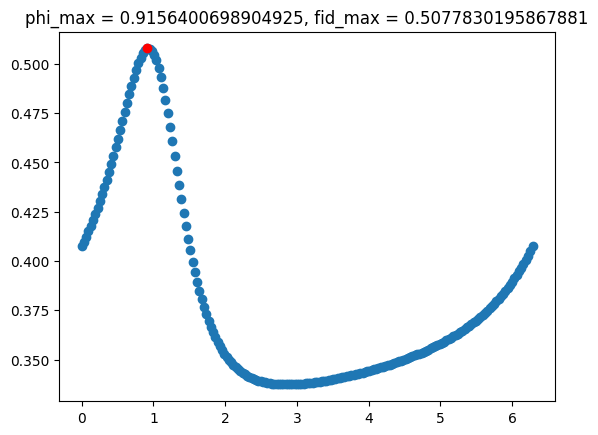

In [52]:
fig = plt.figure()
plt.scatter(philist, fidelities)
plt.scatter(philist[argmax], fidelities[argmax], c='r')
_ = plt.title(f'phi_max = {philist[argmax]}, fid_max = {fidelities[argmax]}')

In [ ]:
#if the same thing is done for slightly different gatetimes, the maximum fidelity / phimax very different

#important takeaway: if we do multiply the propogator by a relative phase in the 11 element--
#we do get a better imperfect fidelity quantity (imperfect because 4x4 not unitary)

## Method 2

In [64]:
_, gatetime, _ = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, False)
h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
newt_vec = np.linspace(t_start, gatetime, 601)

psi0 = qt.tensor(e_state, e_state)
te0 = qt.mesolve(h, psi0, newt_vec, [], [])

expstate = qt.Qobj([te0.states[-1][0][0], te0.states[-1][1][0], te0.states[-1][3][0], te0.states[-1][4][0]])
theostate = SQiSW * qt.Qobj(np.array([0, 0, 0, 1]))
print(qt.fidelity(expstate, theostate))

expstate

0.9965461747681873


Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[-0.00132884+5.59890579e-05j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [-0.99296192+8.44446796e-02j]]

In [82]:
te0.states[-1]

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[-1.32883920e-03+5.59890579e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-4.87916286e-02-3.26473573e-02j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-9.92961920e-01+8.44446796e-02j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-4.87916286e-02-3.26473573e-02j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 4.24362030e-04+9.09180538e-04j]]

In [83]:
te0.states[0]

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [77]:
philist = np.linspace(0, 2*π, 200)
fidelitylist = []
for phi in philist:
    newmatrix = compute_cz(phi) * expstate
    fidelitylist.append(qt.fidelity(newmatrix, theostate))

0.9965461747681874

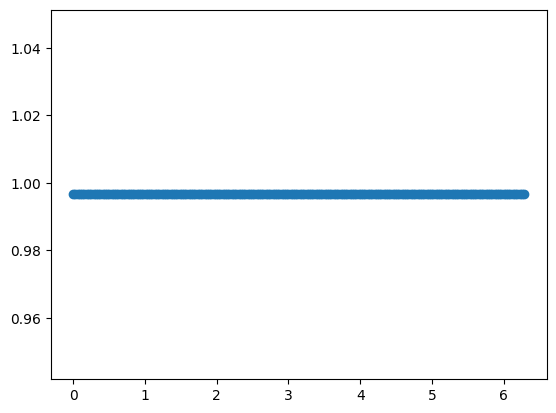

In [81]:
plt.scatter(philist, fidelitylist)
np.max(fidelitylist)

In [ ]:
philist = np.linspace(0, 2*π, 200)
for phi in philist:
    newmatrix = compute_cz(phi) * expstate
    fidelitylist.append(qt.fidelity(newmatrix, theostate))